<a href="https://colab.research.google.com/github/emrllh/My_works/blob/main/Convolutional_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Convolutional Layers

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
#Let's define the default font sizes to make the figures prettier

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
# This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning
import sys
IS_COLAB = 'google.colab' in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. Neural nets can be very slow without a GPU.")

  if IS_COLAB:
    print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
  if IS_KAGGLE:
    print('Go to Settings > Accelerator and select GPU.')


### Implementing Convolutional Layers With Keras
Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [ ]:
from sklearn.datasets import load_sample_images
images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images) # A preprocessing layer which crops images.
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)# rescales images

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps= conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

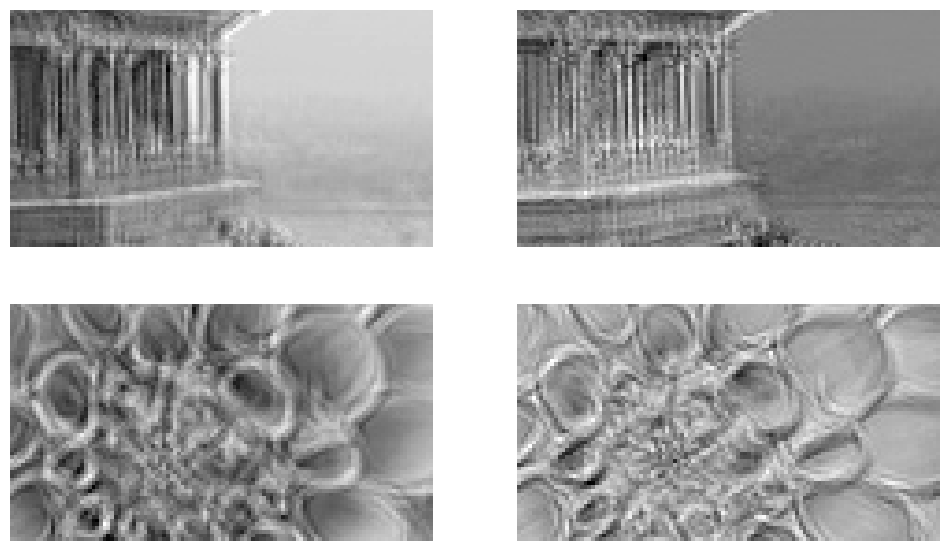

In [ ]:
# Displays the two output feature maps for each image
plt.figure(figsize=(12,7))

for image_idx in (0, 1):
  for fmap_idx in (0, 1):
    plt.subplot(2, 2,  image_idx*2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap= 'gray')
    plt.axis('off')

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [ ]:
# With zero-padding

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding='same')

fmaps = conv_layer(images)

fmaps.shape


TensorShape([2, 70, 120, 32])

Parameters that influence the output shape : -

- The input dimensions of the image — > I (ixi)
- The size of filter/kernel — > F (fxf)
- Strides — > S (integer)
- Padding — > P (integer)
- Depth/Number of feature maps/activation maps — > D (integer)


Convolution Output dimension = [(I - F +2 *P) / S] +1 x D > Formula1

https://kvirajdatt.medium.com/calculating-output-dimensions-in-a-cnn-for-convolution-and-pooling-layers-with-keras-682960c73870

In [ ]:
#The output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same',
                                    strides=2)

fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

 Parameter calculation, the kernel Size is (3x3) with 3 channels (RGB in the input), one bias term, and 5 filters.

- Parameters = (FxF * number of channels + bias-term) * D

In our example Parameters = (3 * 3 * 3 + 1) * 5 = 140

In [ ]:
""" extra code – this utility function can be useful to compute the size of the
feature maps output by a convolutional layer.
It also returns the number of ignored rows or columns if padding="valid", or the
number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding='valid'):
  if padding=='valid':
    z = input_size - kernel_size + strides
    ouput_size = z // strides
    num_ignored = z % strides
    return output_size, num_ignored

  else:
    output_size = (input_size - 1) // strides + 1
    num_padded = (output_size -1) * strides + kernel_size- input_size
    return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding='same')

(array([35, 60]), array([5, 5]))

In [ ]:
#Let's now look at the weights
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
biases.shape

(32,)

For a pooling layer, one can specify only the filter/kernel size (F) and the strides (S).

* Note Depth, D will be same as the previous layer (i.e the depth dimension remains unchanged, in our case D=5 ) — -> Formula2

Pooling Output dimension = [(I - F) / S] + 1 x D

### Pooling Layers

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)
output.shape

TensorShape([2, 35, 60, 3])

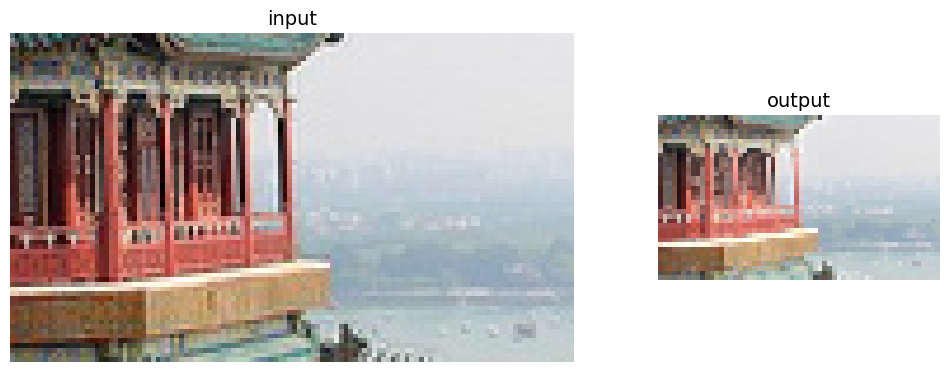

In [ ]:
#this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios =[2,1]) #A grid layout to place subplots within a figure.

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title('input')
ax1.imshow(images[0]) # plotting the first image
ax1.axis('off')

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title('output')
ax2.imshow(output[0]) #plot the output for the first image
ax2.axis('off')
plt.show()

#### Global Average Pooling

In [ ]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [ ]:
#same as above
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1,2])
)

In [ ]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

## CNN Architectures

In [ ]:
"""
loads the mnist dataset, add the channels axis to the inputs,
scales the values to the 0-1 range, and splits the dataset
"""
import numpy as np

mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test,y_test) = mnist


4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train,X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train,y_valid = y_train_full[:-5000],y_train_full[-5000:]

In [ ]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),

    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer='he_normal'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_initializer='he_normal'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')])

In [ ]:
# compiles, fits, evaluates, and uses the model to make predictions

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 25s 10ms/step - loss: 0.7391 - accuracy: 0.7342 - val_loss: 0.3835 - val_accuracy: 0.8650
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4256 - accuracy: 0.8556 - val_loss: 0.3209 - val_accuracy: 0.8848
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3608 - accuracy: 0.8786 - val_loss: 0.2818 - val_accuracy: 0.8996
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3189 - accuracy: 0.8923 - val_loss: 0.2764 - val_accuracy: 0.8956
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2941 - accuracy: 0.9010 - val_loss: 0.2664 - val_accuracy: 0.9042
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2765 - accuracy: 0.9077 - val_loss: 0.2631 - val_accuracy: 0.9044
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2566 - accuracy: 0.9133 - val_loss: 0.2760 - val_a

In [ ]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.2783 - accuracy: 0.9092


In [ ]:
X_new = X_test[:10] #pretend we have new images
y_pred = model.predict(X_new)


1/1 [==============================] - 0s 18ms/step


### LeNet-5

 * MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.

* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the original paper for details.

* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

### Implementing a ResNet-34 CNN Using Keras

In [ ]:
from functools import partial


In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, strides=1,
                        padding='same', kernel_initializer='he_normal', use_bias=False)

In [ ]:

class ResiduleUnit(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', *kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
        DefaultConv2D(filters, strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]

    self.skip_layers = []
    if strides > 1:
      self.skip_layers =[
        DefaultConv2D(filters, kernel_size=1, strides = strides),
        tf.keras.layers.BatchNormalization()
      ]
  def call(self, inputs):

    Z = inputs
    for layers in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])

prev_filters=64
for filter in [64] * 3 + [128] * 4 +[256] * 6 + [512] * 3:
  strides = 1 if filter == prev_filters else 2
  model.add(ResiduleUnit(filter, strides=strides))
  pref_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

TypeError: keras.src.engine.base_layer.Layer.__init__() argument after ** must be a mapping, not tuple

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResiduleUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

TypeError: keras.src.engine.base_layer.Layer.__init__() argument after ** must be a mapping, not tuple

### Using Pretrained Models from Keras

In [ ]:
import tensorflow as tf
model = tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 0s 0us/step


In [ ]:
images = load_sample_images()['images']
image_resized = tf.keras.layers.Resizing(height=224, width=224,
                                         crop_to_aspect_ratio=True)(images)

In [ ]:
inputs = tf.keras.applications.resnet50.preprocess_input(image_resized)

In [ ]:
Y_proba=model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 0s 139ms/step


(2, 1000)

In [ ]:
"""
Decodes the prediction of an ImageNet model.

Args:
  preds: Numpy array encoding a batch of predictions.
  top: Integer, how many top-guesses to return. Defaults to 5.

Returns:
  A list of lists of top class prediction tuples
(class_name, class_description, score).
"""

top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
  print(f'Image #{image_index}')
  for class_id, name, y_proba in top_K[image_index]:
    print(f' {class_id} - {name:12s} {y_proba:.2%}')

Image #0
 n03877845 - palace       54.69%
 n03781244 - monastery    24.71%
 n02825657 - bell_cote    18.55%
Image #1
 n04522168 - vase         32.67%
 n11939491 - daisy        17.82%
 n03530642 - honeycomb    12.04%


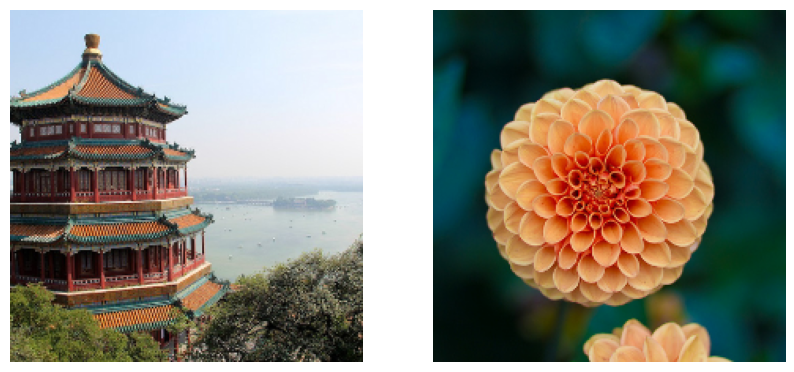

In [ ]:
#displays the cropped and resized images
plt.figure(figsize=(10,6))
for idx in (0,1):
  plt.subplot(1, 2, idx + 1) #subplot(nrows, ncols, index, **kwargs)
  plt.imshow(image_resized[idx] / 255)
  plt.axis('off')

plt.show()


### Pretrained Models for Transfer Learning

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset_size, class_names

(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'])

In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete1SLCSA',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

In [ ]:
test_set_raw,valid_set_raw, train_set_raw

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

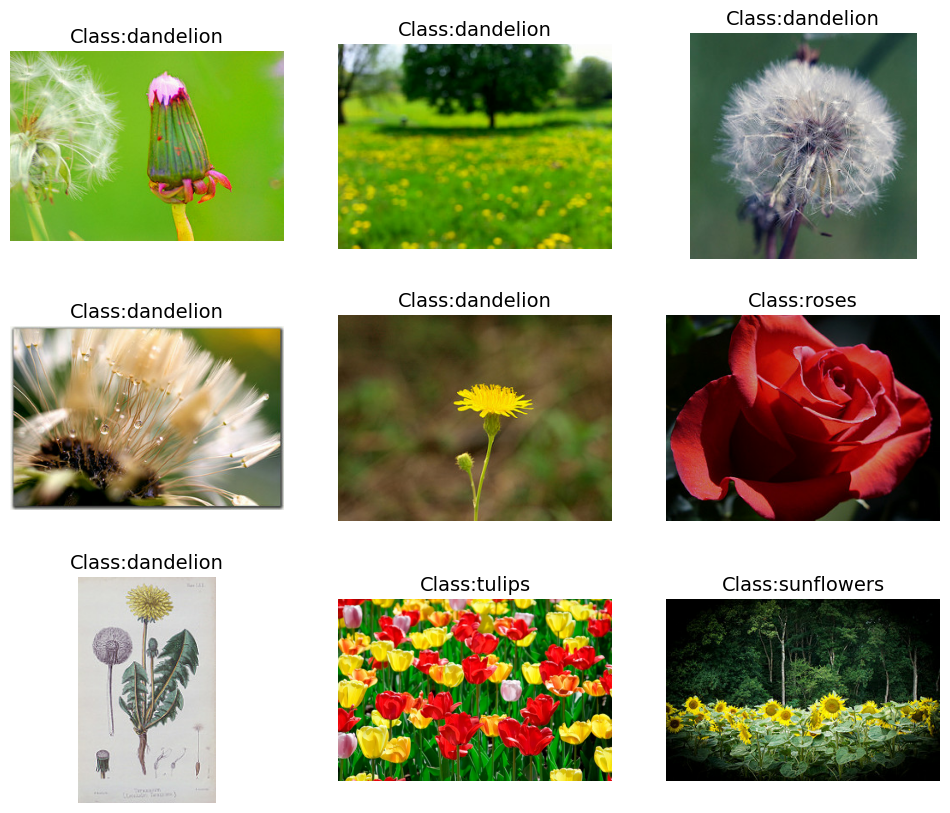

In [ ]:
#displays the first 9 images in the validation set

plt.figure(figsize=(12,10))
index = 0

for image, label in valid_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title(f'Class:{class_names[label]}')
  plt.axis('off')

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a Resizing layer for this. We must also call the tf.keras.applications.xception.preprocess_input() function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [ ]:
#The Lambda layer exists so that arbitrary expressions can be used as a Layer when constructing Sequential and Functional API models.
#Lambda layers are best suited for simple operations or quick experimentation.

tf.keras.backend.clear_session() # Reset the layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio= True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

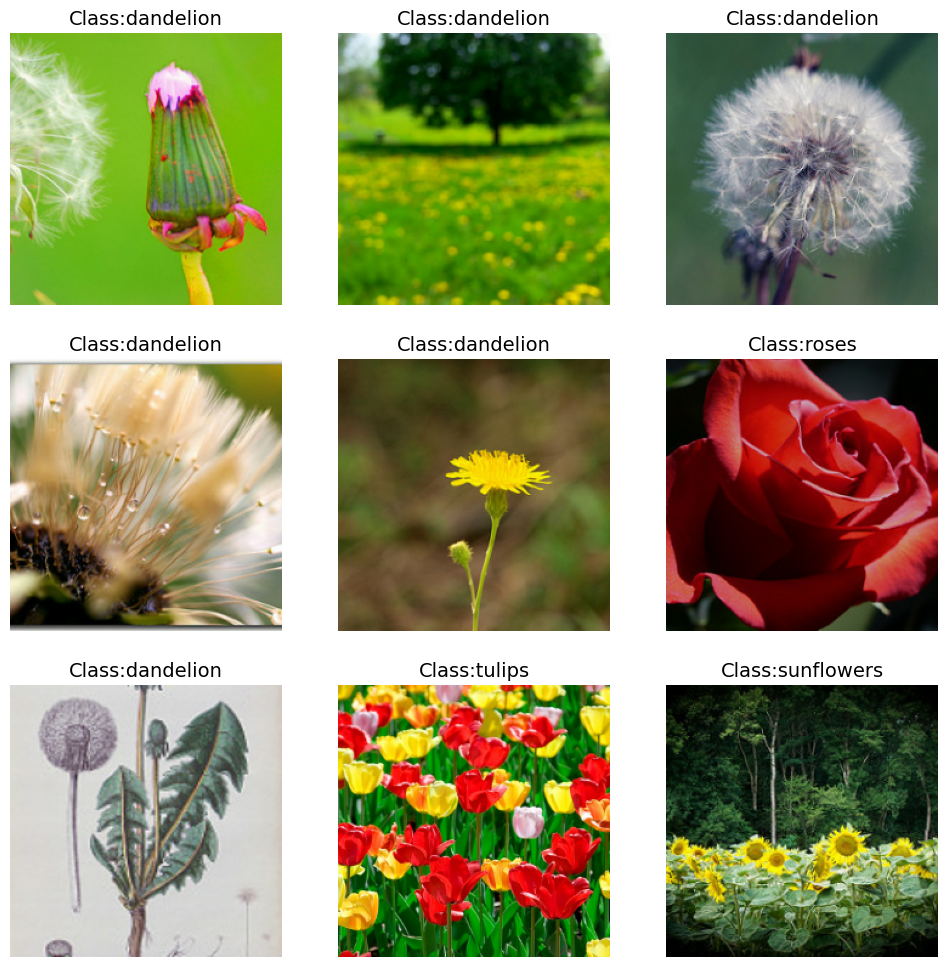

In [ ]:
#Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:
plt.figure(figsize=(12,12))
for X_batch, y_batch in valid_set.take(1):
  for index  in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow((X_batch[index] + 1)/ 2) # rescale to 0–1 for imshow()
    plt.title(f'Class:{class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed= 42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

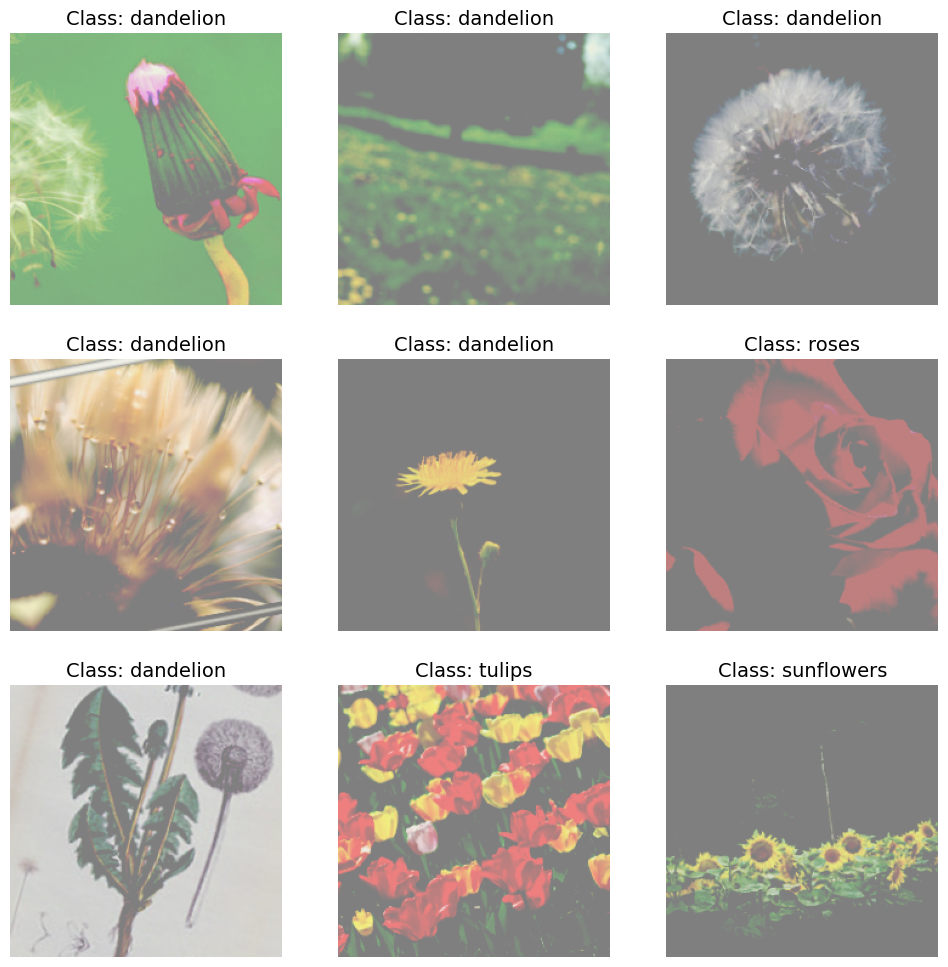

In [ ]:
# displays the same first 9 images, after augmentation
import numpy as np

plt.figure(figsize=(12,12))
for X_batch, y_batch in valid_set.take(1):
  X_batch_augmented = data_augmentation(X_batch, training = True)
  for index in range(9):
    plt.subplot(3, 3, index +1)
    # We must rescale the images to the 0-1 range for imshow(), and also
    # clip the result to that range, because data augmentation may
    # make some values go out of bounds (e.g., RandomContrast in this case)

    plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
    plt.title(f'Class: {class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()




In [ ]:
#Now let's load the pretrained model, without its top layers, and replace them with our own
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
for layer in model.layers:
    sp=' '[len(layer.name):]
    print(layer.name,sp,layer.trainable)

input_1  False
block1_conv1  False
block1_conv1_bn  False
block1_conv1_act  False
block1_conv2  False
block1_conv2_bn  False
block1_conv2_act  False
block2_sepconv1  False
block2_sepconv1_bn  False
block2_sepconv2_act  False
block2_sepconv2  False
block2_sepconv2_bn  False
conv2d  False
block2_pool  False
batch_normalization  False
add  False
block3_sepconv1_act  False
block3_sepconv1  False
block3_sepconv1_bn  False
block3_sepconv2_act  False
block3_sepconv2  False
block3_sepconv2_bn  False
conv2d_1  False
block3_pool  False
batch_normalization_1  False
add_1  False
block4_sepconv1_act  False
block4_sepconv1  False
block4_sepconv1_bn  False
block4_sepconv2_act  False
block4_sepconv2  False
block4_sepconv2_bn  False
conv2d_2  False
block4_pool  False
batch_normalization_2  False
add_2  False
block5_sepconv1_act  False
block5_sepconv1  False
block5_sepconv1_bn  False
block5_sepconv2_act  False
block5_sepconv2  False
block5_sepconv2_bn  False
block5_sepconv3_act  False
block5_sepconv3  F

In [ ]:
#Let's train the model for a few epochs, while keeping the base model weights fixed:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history=model.fit(train_set, validation_data=valid_set, epochs=3)


Epoch 1/3
86/86 [==============================] - 30s 229ms/step - loss: 0.7288 - accuracy: 0.8110 - val_loss: 0.7134 - val_accuracy: 0.8403
Epoch 2/3
86/86 [==============================] - 16s 174ms/step - loss: 0.3219 - accuracy: 0.9095 - val_loss: 0.5451 - val_accuracy: 0.8784
Epoch 3/3
86/86 [==============================] - 16s 183ms/step - loss: 0.1976 - accuracy: 0.9357 - val_loss: 0.5535 - val_accuracy: 0.8838


In [ ]:
for indices in zip(range(33), range(33,66), range(66,99), range(99, 132)):
  for idx in indices:
    print(f'{idx:3}: {base_model.layers[idx].name:22}', end='')

  print()

  0: input_3                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_10 67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_26                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_33                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
#Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again,
# and continue training, but with a lower learning rate:

for layer in base_model.layers[56:]:
  layer.trainable = True

In [ ]:
for layer in model.layers:
    sp=' '[len(layer.name):]
    print(layer.name,sp,layer.trainable)

input_1  False
block1_conv1  False
block1_conv1_bn  False
block1_conv1_act  False
block1_conv2  False
block1_conv2_bn  False
block1_conv2_act  False
block2_sepconv1  False
block2_sepconv1_bn  False
block2_sepconv2_act  False
block2_sepconv2  False
block2_sepconv2_bn  False
conv2d  False
block2_pool  False
batch_normalization  False
add  False
block3_sepconv1_act  False
block3_sepconv1  False
block3_sepconv1_bn  False
block3_sepconv2_act  False
block3_sepconv2  False
block3_sepconv2_bn  False
conv2d_1  False
block3_pool  False
batch_normalization_1  False
add_1  False
block4_sepconv1_act  False
block4_sepconv1  False
block4_sepconv1_bn  False
block4_sepconv2_act  False
block4_sepconv2  False
block4_sepconv2_bn  False
conv2d_2  False
block4_pool  False
batch_normalization_2  False
add_2  False
block5_sepconv1_act  False
block5_sepconv1  False
block5_sepconv1_bn  False
block5_sepconv2_act  False
block5_sepconv2  False
block5_sepconv2_bn  False
block5_sepconv3_act  False
block5_sepconv3  F

In [ ]:
#Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again,
# and continue training, but with a lower learning rate:

for layer in base_model.layers[56:]:
  layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

history= model.fit(train_set, validation_data=valid_set, epochs=10)



Epoch 1/10
86/86 [==============================] - 41s 354ms/step - loss: 0.2604 - accuracy: 0.9113 - val_loss: 0.5871 - val_accuracy: 0.8621
Epoch 2/10
86/86 [==============================] - 28s 320ms/step - loss: 0.0674 - accuracy: 0.9815 - val_loss: 0.4146 - val_accuracy: 0.8966
Epoch 3/10
86/86 [==============================] - 29s 330ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.3304 - val_accuracy: 0.9201
Epoch 4/10
86/86 [==============================] - 29s 327ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.3220 - val_accuracy: 0.9056
Epoch 5/10
86/86 [==============================] - 29s 325ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.3607 - val_accuracy: 0.8984
Epoch 6/10
86/86 [==============================] - 29s 331ms/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 0.3246 - val_accuracy: 0.8966
Epoch 7/10
86/86 [==============================] - 30s 330ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.3292 - val_accuracy: 0.9020

### Classification and Localization

In [ ]:
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes,activation='softmax')(avg)
loc_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])

optimizer= tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#fits the model using random target bounding boxes (in real life you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 8s 679ms/step - loss: 0.5537 - dense_6_loss: 0.6463 - dense_7_loss: 0.1832 - dense_6_accuracy: 0.8562 - dense_7_accuracy: 0.2281
Epoch 2/2
10/10 [==============================] - 7s 568ms/step - loss: 0.3536 - dense_6_loss: 0.3981 - dense_7_loss: 0.1755 - dense_6_accuracy: 0.8875 - dense_7_accuracy: 0.2625


## CNN for MNIST

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
mnist = tf.keras.datasets.mnist.load_data()

(X_train_full, y_train_full), (X_test,y_test) = mnist

X_train, X_valid = X_train_full[:-5000]/255., X_train_full[-5000:]/255.
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_test = X_test/255.


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, X_test.shape

((55000, 28, 28), (10000, 28, 28))

In [ ]:
#numpy.newaxis is used to increase the dimension of the existing array by one more dimension
X_train = X_train[..., np.newaxis] #np.expand_dims(X_train.astype(np.float32), axis=-1) / 255 do same job
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape, X_valid.shape

((55000, 28, 28, 1), (5000, 28, 28, 1))

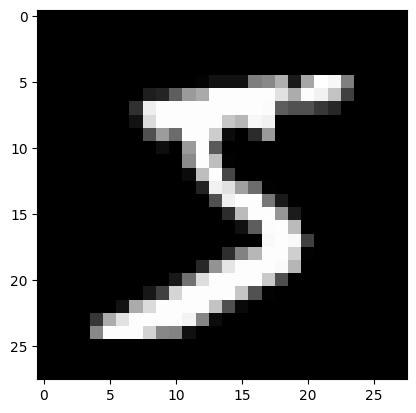

In [ ]:
# view the actual image at index 0
plt.imshow(X_train[0], cmap='gray')

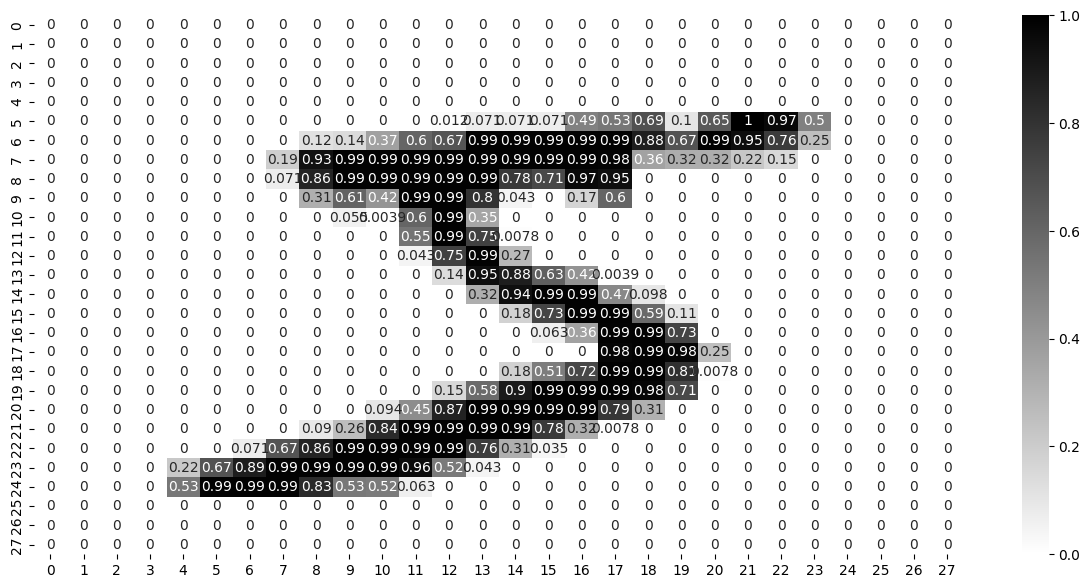

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(X_train[0].reshape(28,28), annot= True, cmap='binary');

In [ ]:
# Lets try 2 ways and then compare the results
from functools import partial

tf.random.set_seed(42)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')

])

In [ ]:
for layer in model.layers:
  sp=''[len(layer.name):]
  print(layer.name, sp,layer.trainable)

conv2d  True
max_pooling2d  True
conv2d_1  True
conv2d_2  True
max_pooling2d_1  True
conv2d_3  True
conv2d_4  True
max_pooling2d_2  True
flatten  True
dense  True
dropout  True
dense_1  True
dropout_1  True
dense_2  True


In [ ]:
# compiles, fits, evaluates, and uses the model to make predictions

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

history= model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 36s 13ms/step - loss: 0.4540 - accuracy: 0.8590 - val_loss: 0.0536 - val_accuracy: 0.9848
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1347 - accuracy: 0.9679 - val_loss: 0.0686 - val_accuracy: 0.9842
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0950 - accuracy: 0.9774 - val_loss: 0.0573 - val_accuracy: 0.9864
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0755 - accuracy: 0.9827 - val_loss: 0.0498 - val_accuracy: 0.9888
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0651 - accuracy: 0.9854 - val_loss: 0.0301 - val_accuracy: 0.9924
Epoch 6/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.0609 - accuracy: 0.9875 - val_loss: 0.0320 - val_accuracy: 0.9932
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0474 - accuracy: 0.9890 - val_loss: 0.0370 - val

In [ ]:
score = model.evaluate(X_test,y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0445 - accuracy: 0.9914


In [ ]:
X_new =X_test[:2] #pretend we have new images
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 282ms/step


In [ ]:
# show the inputs and predicted outputs
#for i in range(len(X_new)):
  #print()
  #print('X=%s, Predicted=%s' %(X_new[i], y_pred[i]))



In [ ]:
#2. way of creating model
"""if you are creating many models in a loop, this global state will consume
an increasing amount of memory over time, and you may want to clear it.
Calling clear_session() releases the global state: this helps avoid
clutter from old models and layers, especially when memory is limite"""

tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same',
                           activation='relu', kernel_initializer='he_normal'),

    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same',
                           activation='relu', kernel_initializer='he_normal'),

    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

history= model.fit(X_train,y_train, epochs=10,
                   validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 17s 6ms/step - loss: 0.1422 - accuracy: 0.9571 - val_loss: 0.0492 - val_accuracy: 0.9860
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0584 - accuracy: 0.9819 - val_loss: 0.0415 - val_accuracy: 0.9874
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0393 - accuracy: 0.9882 - val_loss: 0.0396 - val_accuracy: 0.9886
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0297 - accuracy: 0.9904 - val_loss: 0.0444 - val_accuracy: 0.9892
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0262 - accuracy: 0.9916 - val_loss: 0.0303 - val_accuracy: 0.9918
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0367 - val_accuracy: 0.9908
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 0.0355 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined